# Assignment 4: Food, Halloween, and Analytics

In this assignment you will practice crawling to fetch data from a website (allrecipes.com).

You will then put your data into a Pandas dataframe and perform some analysis of the fetched recipes.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
!sudo pip3 install -U statsmodels

The directory '/home/ubuntu/.cache/pip/http' or its parent directory is not owned by the current user and the cache has been disabled. Please check the permissions and owner of that directory. If executing pip with sudo, you may want sudo's -H flag.
The directory '/home/ubuntu/.cache/pip' or its parent directory is not owned by the current user and caching wheels has been disabled. check the permissions and owner of that directory. If executing pip with sudo, you may want sudo's -H flag.
Requirement already up-to-date: statsmodels in /usr/local/lib/python3.6/dist-packages (0.9.0)


In [3]:
from lxml import html
from xml.etree import ElementTree
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import requests
import seaborn as sns
import statsmodels.formula.api as smf
matplotlib.style.use(['seaborn-talk', 'seaborn-ticks', 'seaborn-whitegrid'])
import warnings
warnings.filterwarnings('ignore')

## Task 1: Crawl AllRecipes.com

We are getting ready for Halloween, and we want to cook some good food. No, good is not good enough. We want to first the BEST recipe for Heloween.

But to find the best recipe, we need data. 

After a 1-min Google search, we find the page `https://www.allrecipes.com/recipes/189/holidays-and-events/halloween/` that contains recipes for Halloween. From a quick look on the webpage, we see that, for each recipe we have a **star rating**, and we also have the **number of reviews** for the recipe.

So, you need to write a crawler that will parse AllRecipes and fetch data for the recipes. For this assignment, we will only fetch the data from the recipes from the results page; we will not fetch the recipes themselves.  We need to fetch the title of the recipe, the URL for the recipe, the number of reviews, and the average star rating (out of 5 stars).

Tips:

* The URLs for the pages with the recipes have the form `https://www.allrecipes.com/recipes/189/holidays-and-events/halloween/?page=...` with the page parameter taking values from 1 and above.
* Each recipe entry is stored under HTML nodes marked as `<article @class="fixed-recipe-card">`. You need to parse these nodes to get the information for each recipe.
* To get the number of reviews, you may need to take a look at the HTML source using the "View Source" capability. The "developer view" hides the fact that the number is not text but part of an HTML tag (e.g., the number 2004 will be listed as `<format-large-number number="2004"></format-large-number>`)

In [4]:
test_url = 'https://www.allrecipes.com/recipes/189/holidays-and-events/halloween/?page=1'
doc = html.fromstring(requests.get(test_url).text)

In [5]:
def get_calories(recipe_url):
    doc = html.fromstring(requests.get(recipe_url).text)
    calories = doc.xpath('//span[@itemprop="calories"]')[0].text.split()[0]
    return int(calories)

In [6]:
get_calories("https://www.allrecipes.com/recipe/152418/caramelized-spicy-pumpkin-seeds/")

117

In [7]:
# Template code to get you started. This code gets as input an HTML page and extracts the list
# of recipes that are listed there.

def get_recipes_from_page(url):
    doc = html.fromstring(requests.get(url).text)
    recipes = doc.xpath('//article[@class="fixed-recipe-card"]')

    result = []
    count = 0
    for r in recipes:
        
        # DEBUGING CODE. Use it to print out the HTML of the "recipe card"
        #html_str = ElementTree.tostring(r).decode()
        #print(html_str)
        #print("=============================\n=============================\n=============================")
        #continue
   
        ### WRITE YOUR CODE HERE. 
        # Your XPath queries should identify the corresponding parts of the page 
        # that contain the information that you need. 
        title = r.xpath('.//span[@class="fixed-recipe-card__title-link"]')[count].text
        recipe_url = r.xpath(".//a[@class='fixed-recipe-card__title-link']")[count].get("href")        
        rating = r.xpath(".//span[contains(@class, 'stars')]")[count].get("data-ratingstars")
        reviews = r.xpath(".//format-large-number")[count].get("number")
        try:
            calories = get_calories(recipe_url)
        except:
            calories = -1
            print("This page has no calories information:")
            print(recipe_url)
            print("==========================================")
        
        # If you feel adventurous: write a crawler that connects to the 
        # main page of the recipe, and fetched the calories
        # calories = get_calories(recipe_url)
        
        entry = {
            'title' : title,
            'recipe_url' : recipe_url,
            'rating' : round(float(rating),2),
            'reviews' : int(reviews),
            'calories' : calories
        }
        result.append(entry)
        count += 1
    return result

In [8]:
test_url = 'https://www.allrecipes.com/recipes/189/holidays-and-events/halloween/?page=1'
get_recipes_from_page(test_url)

[{'calories': 67,
  'rating': 4.67,
  'recipe_url': 'https://www.allrecipes.com/recipe/219207/monster-bites/',
  'reviews': 2005,
  'title': 'Monster Bites '},
 {'calories': 83,
  'rating': 4.8,
  'recipe_url': 'https://www.allrecipes.com/recipe/13768/roasted-pumpkin-seeds/',
  'reviews': 730,
  'title': 'Roasted Pumpkin Seeds'},
 {'calories': 124,
  'rating': 4.65,
  'recipe_url': 'https://www.allrecipes.com/recipe/67656/cake-balls/',
  'reviews': 304,
  'title': 'Cake Balls'},
 {'calories': 117,
  'rating': 4.5,
  'recipe_url': 'https://www.allrecipes.com/recipe/240007/peanut-butter-spider-cookies/',
  'reviews': 297,
  'title': 'Peanut Butter Spider Cookies'},
 {'calories': 966,
  'rating': 4.84,
  'recipe_url': 'https://www.allrecipes.com/recipe/128644/halloween-bloody-baked-rats/',
  'reviews': 685,
  'title': 'Halloween Bloody Baked Rats'},
 {'calories': 156,
  'rating': 4.53,
  'recipe_url': 'https://www.allrecipes.com/recipe/21468/witches-brew/',
  'reviews': 17,
  'title': "Wi

In [9]:
# This code will go through the first 50 pages of the results, extracting recipes
# Once a page returns back 0 recipes, we stop

# We store our results in this list
allrecipes = []
for page in range(1,50):
    url = 'https://www.allrecipes.com/recipes/189/holidays-and-events/halloween/?page=' + str(page)
    # We get back a list of dictionaries for each page; each dictionary corresponds to a recipe
    recipes = get_recipes_from_page(url)
    print(f"Found {len(recipes)} recipes in page {page}")
    if len(recipes) == 0:
        break
    allrecipes.extend(recipes)
    
print(f"We extracted a total of {len(allrecipes)} recipes")

Found 29 recipes in page 1
Found 20 recipes in page 2
Found 20 recipes in page 3
This page has no calories information:
https://www.allrecipes.com/recipe/24483/green-grog/
Found 20 recipes in page 4
Found 20 recipes in page 5
Found 20 recipes in page 6
Found 20 recipes in page 7
Found 20 recipes in page 8
Found 20 recipes in page 9
Found 20 recipes in page 10
Found 20 recipes in page 11
Found 20 recipes in page 12
This page has no calories information:
https://www.allrecipes.com/recipe/40304/swamp-frog/
Found 20 recipes in page 13
Found 20 recipes in page 14
Found 20 recipes in page 15
This page has no calories information:
https://www.allrecipes.com/recipe/148558/candy-apple-martini/
Found 20 recipes in page 16
This page has no calories information:
https://www.allrecipes.com/recipe/125733/bobbing-for-apples/
Found 20 recipes in page 17
This page has no calories information:
https://www.allrecipes.com/recipe/229404/oreo-spider-web-cookie-pizza/
Found 20 recipes in page 18
Found 20 rec

In [10]:
# Create a dataframe with the recipes
df = pd.DataFrame(allrecipes)
df.head(10)

,calories,rating,recipe_url,reviews,title
0,67,4.67,https://www.allrecipes.com/recipe/219207/monst...,2005,Monster Bites
1,83,4.80,https://www.allrecipes.com/recipe/13768/roaste...,730,Roasted Pumpkin Seeds
2,124,4.65,https://www.allrecipes.com/recipe/67656/cake-b...,304,Cake Balls
3,117,4.50,https://www.allrecipes.com/recipe/240007/peanu...,297,Peanut Butter Spider Cookies
4,966,4.84,https://www.allrecipes.com/recipe/128644/hallo...,685,Halloween Bloody Baked Rats
5,156,4.53,https://www.allrecipes.com/recipe/21468/witche...,17,Witches' Brew
6,42,4.74,https://www.allrecipes.com/recipe/219206/hallo...,78,Halloween Fruit Apple Teeth Treats
7,204,4.67,https://www.allrecipes.com/recipe/228246/witch...,78,Witches' Hats
8,377,4.60,https://www.allrecipes.com/recipe/216230/blood...,64,Bloody Broken Glass Cupcakes
9,109,4.78,https://www.allrecipes.com/recipe/10402/the-be...,231,The Best Rolled Sugar Cookies


## Task 2: Descriptive Statistics on Recipes

We now start analyzing the recipes. 

a. Use the `describe()` and `hist()` commands to analyze the contents of the `reviews` and `rating` columns.

In [11]:
df.reviews.describe()

count       631.000000
mean       1168.095087
std       11362.640840
min           0.000000
25%           2.500000
50%          11.000000
75%          51.000000
max      187980.000000
Name: reviews, dtype: float64

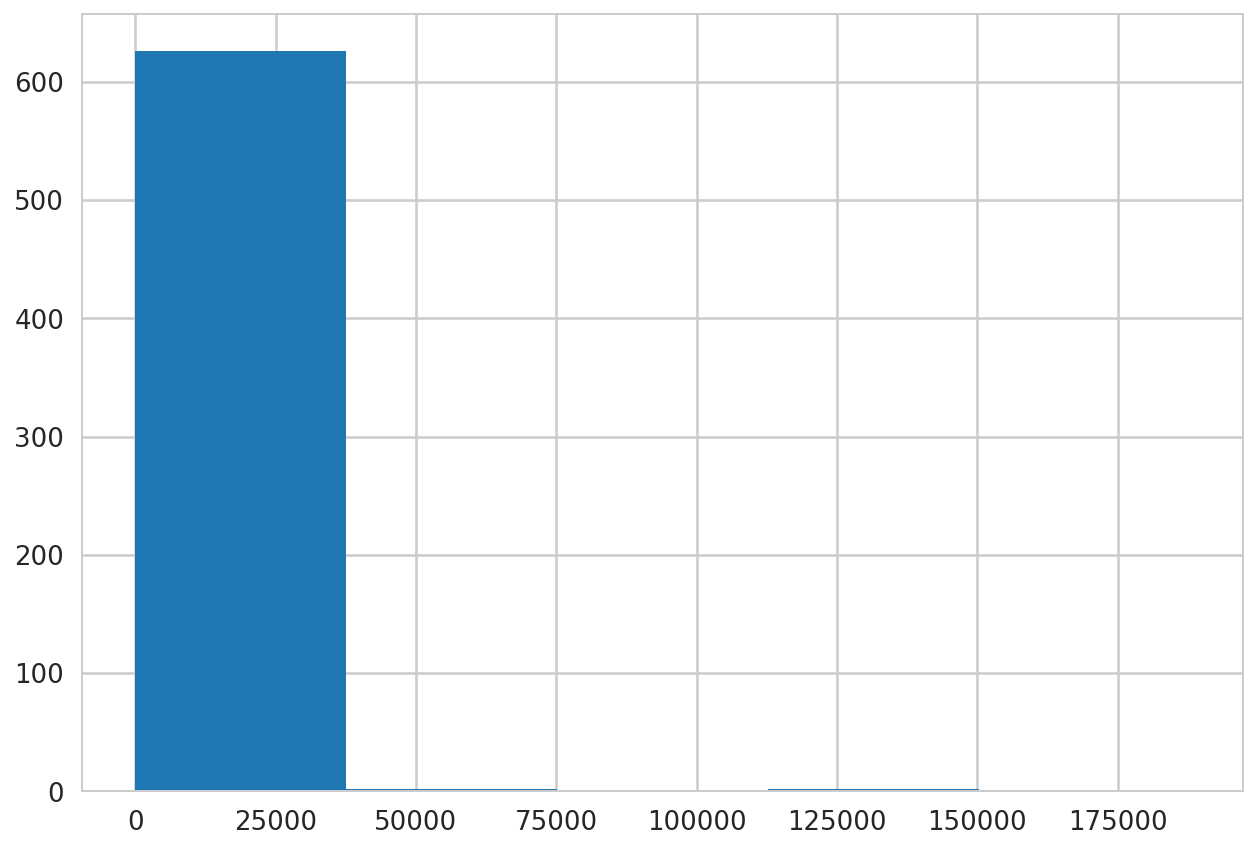

In [24]:
df.reviews.hist()

In [13]:
df.rating.describe()

count    631.000000
mean       3.857559
std        1.472150
min        0.000000
25%        4.000000
50%        4.420000
75%        4.655000
max        5.000000
Name: rating, dtype: float64

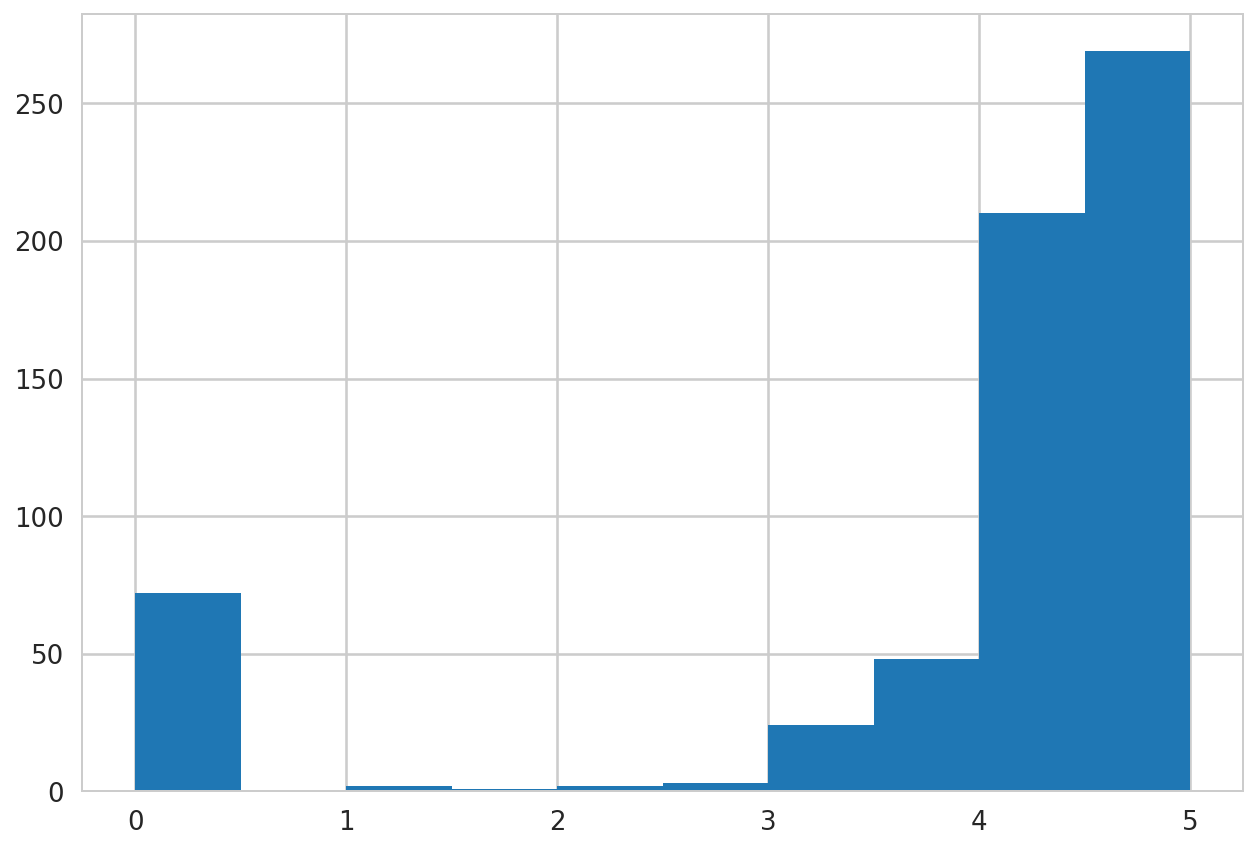

In [14]:
df.rating.hist()

b. Find the recipe with the highest number of reviews

In [15]:
df.sort_values('reviews',ascending=False)[:1]

,calories,rating,recipe_url,reviews,title
18,167,4.5,https://www.allrecipes.com/recipe/80773/russia...,187980,Russian Mushroom and Potato Soup


c. Based on the results of the first exploratory analysis, you decide to keep only recipes more than 10 reviews, and with rating above 4.5. Create a new dataframe with only these well-reviewed, and highly-rated recipes.

In [16]:
df_filtered = df[(df["reviews"] > 10) & (df["rating"] >4.5)]
df_filtered.head(10)

,calories,rating,recipe_url,reviews,title
0,67,4.67,https://www.allrecipes.com/recipe/219207/monst...,2005,Monster Bites
1,83,4.80,https://www.allrecipes.com/recipe/13768/roaste...,730,Roasted Pumpkin Seeds
2,124,4.65,https://www.allrecipes.com/recipe/67656/cake-b...,304,Cake Balls
4,966,4.84,https://www.allrecipes.com/recipe/128644/hallo...,685,Halloween Bloody Baked Rats
5,156,4.53,https://www.allrecipes.com/recipe/21468/witche...,17,Witches' Brew
6,42,4.74,https://www.allrecipes.com/recipe/219206/hallo...,78,Halloween Fruit Apple Teeth Treats
7,204,4.67,https://www.allrecipes.com/recipe/228246/witch...,78,Witches' Hats
8,377,4.60,https://www.allrecipes.com/recipe/216230/blood...,64,Bloody Broken Glass Cupcakes
9,109,4.78,https://www.allrecipes.com/recipe/10402/the-be...,231,The Best Rolled Sugar Cookies
13,155,4.64,https://www.allrecipes.com/recipe/8372/black-m...,1200,Black Magic Cake


d. Among the recipes with more than 10 reviews, find the one with the highest rating. The command `df.rating.max()` returns back the highest value for the column `rating` of the dataframe `df`.

In [17]:
max_rating = (df_filtered["rating"] == df_filtered.rating.max())
df_filtered[max_rating]

,calories,rating,recipe_url,reviews,title
189,208,4.96,https://www.allrecipes.com/recipe/143055/broil...,35,Broiler S'mores


e. Find all the recipes with more than 10 reviews, and with rating above 4.5, that contain the word 'Cookie' in the title. The command `df.title.str.contains('Cookie')` can be used for this purpose.

In [18]:
contains_cookie = (df["title"].str.contains('Cookie'))
df_filtered[contains_cookie]

,calories,rating,recipe_url,reviews,title
9,109,4.78,https://www.allrecipes.com/recipe/10402/the-be...,231,The Best Rolled Sugar Cookies
33,543,4.58,https://www.allrecipes.com/recipe/10949/pumpki...,74445,Pumpkin Cookies V
59,115,4.54,https://www.allrecipes.com/recipe/11618/pumpki...,217,Pumpkin Cookies I
87,146,4.55,https://www.allrecipes.com/recipe/11288/egg-fr...,132,Egg Free Chocolate Chip Pumpkin Cookies
90,128,4.66,https://www.allrecipes.com/recipe/228740/pumpk...,137,Pumpkin Oatmeal Chocolate Chip Cookies
100,128,4.70,https://www.allrecipes.com/recipe/10385/pumpki...,111,Pumpkin Cookies with Penuche Frosting
110,119,4.68,https://www.allrecipes.com/recipe/10671/pumpki...,93,Pumpkin Cookies III
112,152,4.57,https://www.allrecipes.com/recipe/229108/pumpk...,84,Pumpkin Cookies with Cream Cheese Frosting (Th...
130,132,4.67,https://www.allrecipes.com/recipe/216459/acorn...,67,Acorn Candy Cookies
168,22,4.61,https://www.allrecipes.com/recipe/229105/shiny...,48,Shiny Cookie Icing


f. Using the dataframe from step (c), create a scatterplot that shows the number of reviews on the x-axis and the recipe rating on the y axis.

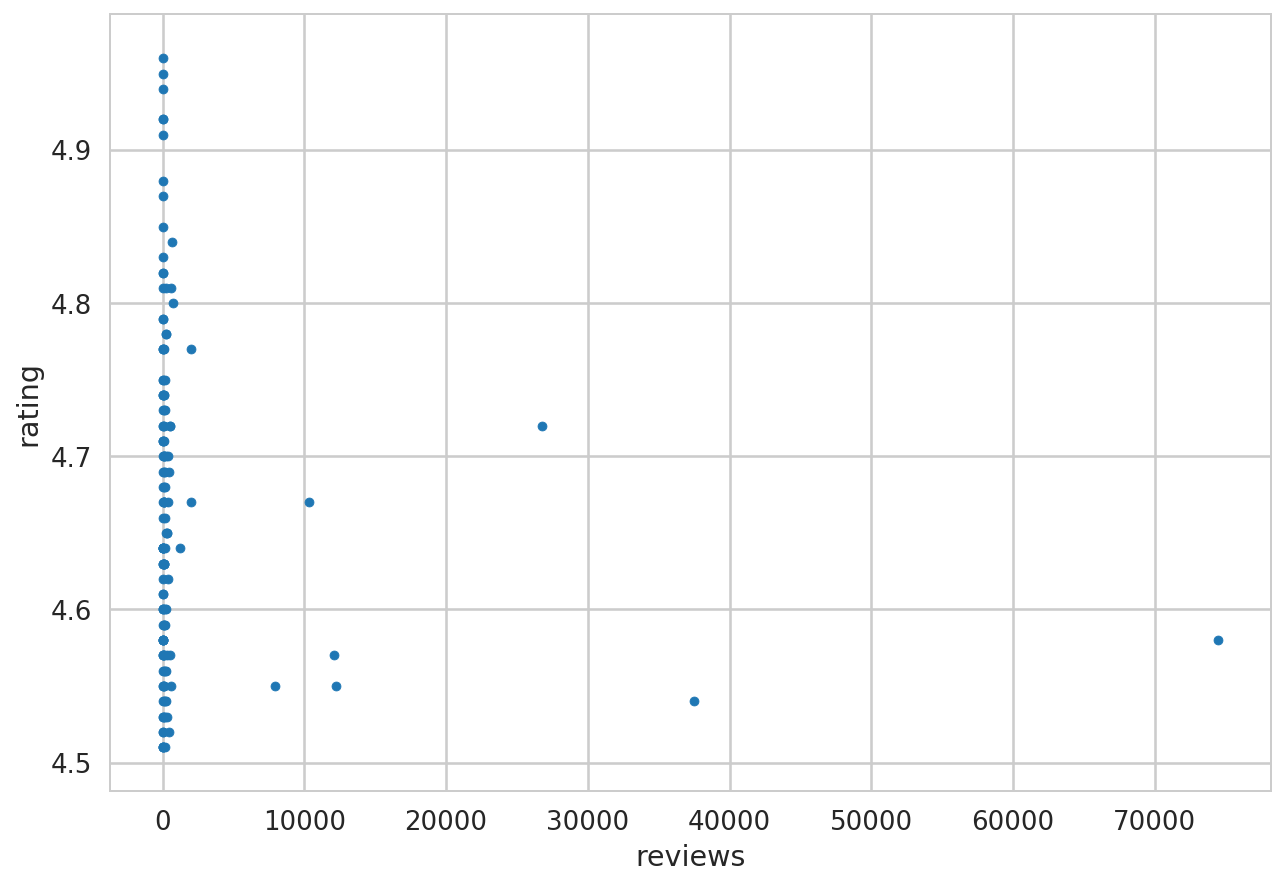

In [19]:
df_filtered.plot(
    kind = "scatter",
    x = "reviews",
    y = "rating"
)

g. Use `statsmodels` and run an OLS regression examining if there is a correlation between the number of reviews and the recipe rating. The code below takes as input a dataframe `df` and runs a regression of column `Y` against columns `X1` and `X2`.

```python
results = smf.ols('Y ~ X1 + X2', data=df).fit()
print(results.summary())
```

Examine the returned coefficients and explain if there is a statistically significant effect. 


In [20]:
results = smf.ols('reviews ~ rating', data=df_filtered).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                reviews   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     1.768
Date:                Mon, 22 Oct 2018   Prob (F-statistic):              0.186
Time:                        13:52:02   Log-Likelihood:                -1486.2
No. Observations:                 144   AIC:                             2976.
Df Residuals:                     142   BIC:                             2982.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   3.734e+04    2.7e+04      1.381      0.1

h. (**Very Hard**; optional) Find the Pareto-optimal set of recipes. A recipe belongs to the Pareto-optimal set if there is no other recipe that dominates it. We say that a recipe A dominates recipe B if `(A.rating >= B.rating and A.reviews >= B.reviews)`. Do the same for recipes that contain the word `Cookie`.

In [21]:
cookie = df_filtered[contains_cookie]
dominate = cookie.iloc[0]

for index, row in cookie.iterrows():
    if row['rating'] >= dominate['rating'] and row['reviews'] >= dominate['reviews']:
        dominate = row

print(dominate)

calories                                                    109
rating                                                     4.78
recipe_url    https://www.allrecipes.com/recipe/10402/the-be...
reviews                                                     231
title                             The Best Rolled Sugar Cookies
Name: 9, dtype: object
